In [7]:
pip install opencv-python

You should consider upgrading via the '/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tqdm

     |████████████████████████████████| 78 kB 5.1 MB/s             
You should consider upgrading via the '/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install matplotlib

     |████████████████████████████████| 7.2 MB 5.5 MB/s            
     |████████████████████████████████| 63 kB 8.6 MB/s             
     |████████████████████████████████| 2.8 MB 13.1 MB/s            
     |████████████████████████████████| 930 kB 8.6 MB/s            
You should consider upgrading via the '/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

## Script to plot all pre and post-processed pictures from a path directory

img_name: 1_curve_whitesegment.png
img_name: 3_driftingleft.png
img_name: 3_redtriangle.png
img_name: 2_driftingright.png
img_name: 4_curve_whiteline.png
img_name: 5_number.png
img_name: 4_whitelines.png
img_name: 4_curve_blue.png
img_name: 5_curve_blue.png
img_name: 6_straight.png
img_name: 1_straight.png
img_name: 4_curve_whitelines.png
img_name: 4_bluetriangle.png
img_name: 6_horizontalwhite.png
img_name: 4_whitehorizontal.png


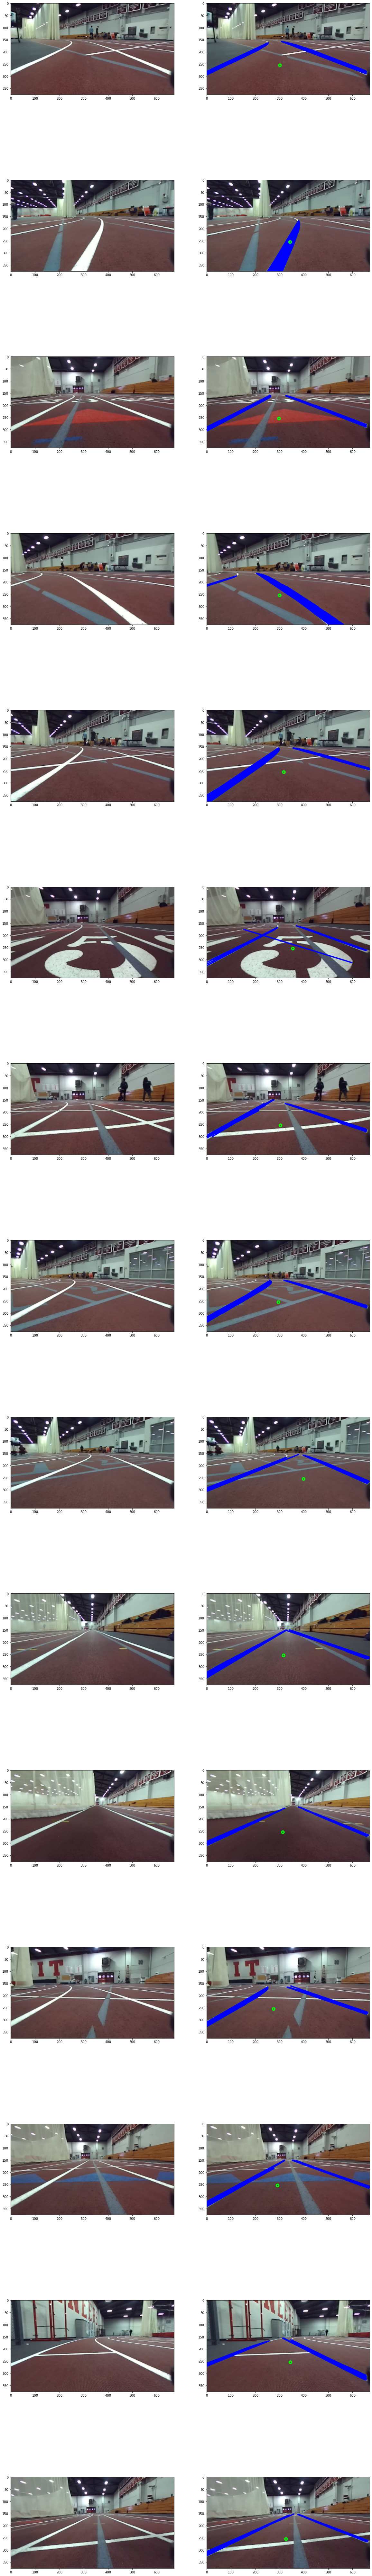

In [4]:
from scripts.image_processing import find_goal_point

imgs_dir = "../media/TrackPics/"#"../media/track_run_pics/"
rgb_imgs = []
# imgs = [cv2.imread(os.path.join(imgs_dir, img_name)) for img_name in os.listdir(imgs_dir)]
for img_name in os.listdir(imgs_dir):
    print("img_name:", img_name)
    image = cv2.imread(os.path.join(imgs_dir, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgb_imgs.append(image) 

num_pics = len(rgb_imgs)

_, axs = plt.subplots(num_pics, 2, figsize=(20, num_pics*10))

for i in range(num_pics):
    axs[i][0].imshow(rgb_imgs[i])
    _, new_image = find_goal_point(rgb_imgs[i], display=False, ret_image=True)
    axs[i][1].imshow(new_image)
    

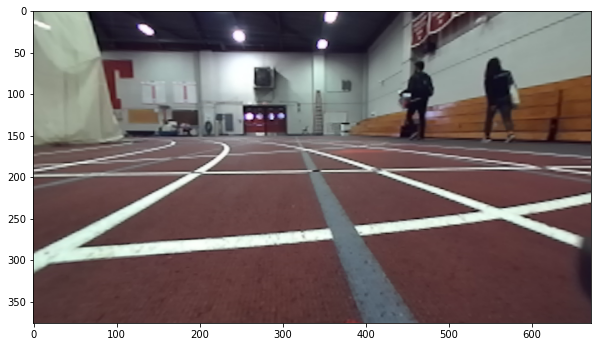

In [12]:
test_image_path="../media/TrackPics/4_whitelines.png"
image = cv2.imread(test_image_path)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
print(image.shape)

(376, 672, 3)


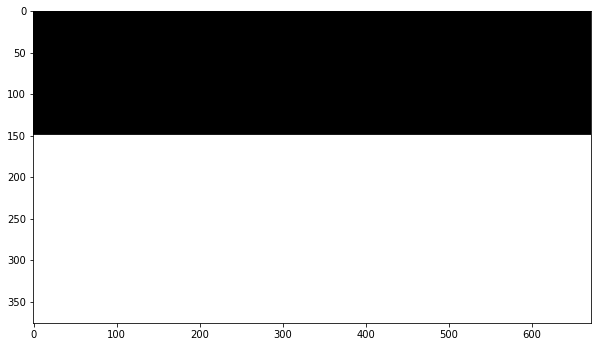

In [14]:
# create a zero array
stencil = np.zeros_like(image[:,:,0])
# specify coordinates of the polygon
#polygon = np.array([[-150,376], [280,160], [400,160], [1100,376]])
polygon = np.array([[0,376], [0,150], [672,150], [672,376]])
# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

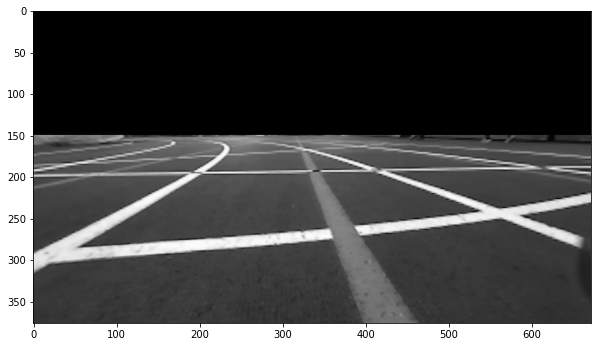

In [15]:
# apply polygon as a mask on the frame
img = cv2.bitwise_and(image[:,:,0], image[:,:,0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

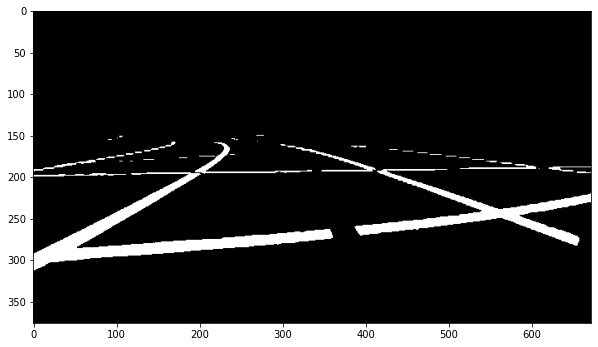

In [16]:
# apply image thresholding
ret, thresh = cv2.threshold(img, 165, 200, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

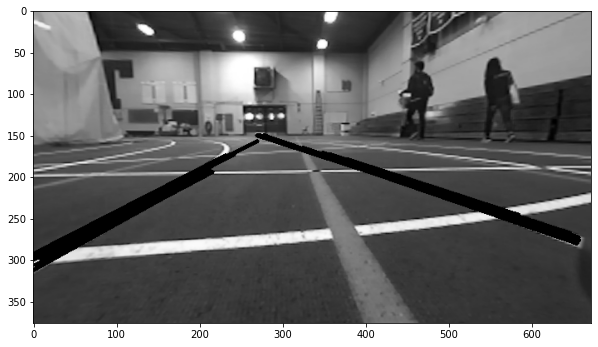

In [17]:
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 60, maxLineGap=200)
lines_filtered = []
# create a copy of the original frame
dmy = image[:,:,0].copy()

# draw Hough lines
for line in lines:
  x1, y1, x2, y2 = line[0]
  
  m = (y2-y1)/(x2-x1)
  if (abs(m) > 0.3):
      lines_filtered.append(line)
      cv2.line(dmy, (x1, y1), (x2, y2), (0, 0, 0), 3)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(dmy, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
lines_filtered

[array([[  2, 295, 242, 173]], dtype=int32),
 array([[  0, 294, 270, 157]], dtype=int32),
 array([[348, 171, 647, 268]], dtype=int32),
 array([[324, 165, 657, 273]], dtype=int32),
 array([[  0, 299, 207, 194]], dtype=int32),
 array([[  1, 297, 213, 189]], dtype=int32),
 array([[ 10, 296, 211, 194]], dtype=int32),
 array([[  1, 292, 232, 174]], dtype=int32),
 array([[ 10, 298, 215, 194]], dtype=int32),
 array([[272, 150, 657, 275]], dtype=int32),
 array([[269, 150, 657, 276]], dtype=int32),
 array([[378, 179, 585, 246]], dtype=int32),
 array([[  0, 295, 241, 173]], dtype=int32),
 array([[  4, 306, 216, 194]], dtype=int32),
 array([[  2, 306, 212, 194]], dtype=int32),
 array([[277, 150, 655, 280]], dtype=int32),
 array([[512, 230, 657, 277]], dtype=int32),
 array([[  8, 298, 176, 212]], dtype=int32),
 array([[  2, 292, 237, 173]], dtype=int32),
 array([[357, 173, 573, 243]], dtype=int32),
 array([[  1, 299, 208, 194]], dtype=int32),
 array([[  0, 312, 213, 194]], dtype=int32)]

(276, 225)


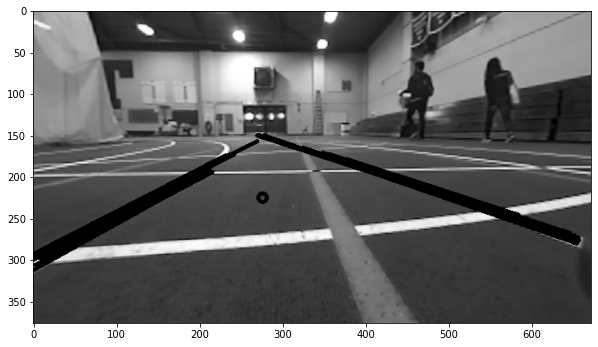

In [18]:
y_lookahead = 225
sumx = 0;

for line in lines_filtered:
  x1, y1, x2, y2 = line[0]
  
  m = (y2-y1)/(x2-x1)
  b = y2-(m*x2)
    
  x_lookahead = (y_lookahead-b)/m
  sumx += x_lookahead

avgx = sumx/(len(lines_filtered))

cv2.circle(dmy, (int(avgx), int(y_lookahead)), 5, (0, 0, 0), 3)
print((int(avgx), int(y_lookahead)))
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(dmy, cv2.COLOR_BGR2RGB))
plt.show()